In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

smallpox_data = genfromtxt('smallpox.csv', delimiter=',') #in the form of [t, S ,En ,Ei ,Ci ,I ,Q ,U, V]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'smallpox' 

class DINN(nn.Module):
    def __init__(self, t, S_data, En_data, Ei_data, Ci_data, I_data, Q_data, U_data, V_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.En = torch.tensor(En_data)
        self.Ei = torch.tensor(Ei_data)
        self.Ci = torch.tensor(Ci_data)
        self.I = torch.tensor(I_data)
        self.Q = torch.tensor(Q_data)
        self.U = torch.tensor(U_data)
        self.V = torch.tensor(V_data)
        self.N = torch.tensor(7000)
        
        self.phi = torch.tensor(self.I/self.S)

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.chi_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.06)
        self.chi_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.04)
        self.epsilon_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.975)
        self.epsilon_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.3)
        self.rho_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.975)
        self.theta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.95)
        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.0685)
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.116)
        

        #matrices (x8 for S ,En ,Ei ,Ci ,I ,Q ,U, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 8)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 8)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 8)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 8)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 8)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 8)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 8)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 8)); self.m8[:, 7] = 1

        #values for norm
        self.S_max = max(self.S)
        self.S_min = min(self.S)
        self.En_max = max(self.En)
        self.En_min = min(self.En)
        self.Ei_max = max(self.Ei)
        self.Ei_min = min(self.Ei)
        self.Ci_max = max(self.Ci)
        self.Ci_min = min(self.Ci)
        self.I_max = max(self.I)
        self.I_min = min(self.I)
        self.Q_max = max(self.Q)
        self.Q_min = min(self.Q)
        self.U_max = max(self.U)
        self.U_min = min(self.U)
        self.V_max = max(self.V)
        self.V_min = min(self.V)

        #normalize 
        self.S_hat = (self.S - self.S_min)/(self.S_max - self.S_min)
        self.En_hat = (self.En - self.En_min)/(self.En_max - self.En_min)
        self.Ei_hat = (self.Ei - self.Ei_min)/(self.Ei_max - self.Ei_min)
        self.Ci_hat = (self.Ci - self.Ci_min)/(self.Ci_max - self.Ci_min)
        self.I_hat = (self.I - self.I_min)/(self.I_max - self.I_min)
        self.Q_hat = (self.Q - self.Q_min)/(self.Q_max - self.Q_min)
        self.U_hat = (self.U - self.U_min)/(self.U_max - self.U_min)
        self.V_hat = (self.V - self.V_min)/(self.V_max - self.V_min)

        #NN
        self.net_smallpox = self.Net_smallpox()
        self.params = list(self.net_smallpox.parameters())
        self.params.extend(list([self.chi_1_tilda ,self.chi_2_tilda ,self.epsilon_1_tilda ,self.epsilon_2_tilda ,self.rho_tilda ,self.theta_tilda ,self.alpha_tilda ,self.gamma_tilda]))

        
    #force parameters to be in a range
    @property
    def chi_1(self):
        return torch.tanh(self.chi_1_tilda) * 0.006 + 0.06
    @property
    def chi_2(self):
        return torch.tanh(self.chi_2_tilda) * 0.004 + 0.04
    @property
    def epsilon_1(self):
        return torch.tanh(self.epsilon_1_tilda) * 0.01 + 0.975
    @property
    def epsilon_2(self):
        return torch.tanh(self.epsilon_2_tilda) * 0.03 + 0.3
    @property
    def rho(self):
        return torch.tanh(self.rho_tilda) * 0.001 + 0.975
    @property
    def theta(self):
        return torch.tanh(self.theta_tilda) * 0.09 + 0.95
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 0.007 + 0.068
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) * 0.01 + 0.11

    #nets
    class Net_smallpox(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_smallpox, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 8) #outputs S ,En ,Ei ,Ci ,I ,Q ,U, V

        def forward(self, t):
            smallpox=F.relu(self.fc1(t))
            smallpox=F.relu(self.fc2(smallpox))
            smallpox=F.relu(self.fc3(smallpox))
            smallpox=F.relu(self.fc4(smallpox))
            smallpox=F.relu(self.fc5(smallpox))
            smallpox=F.relu(self.fc6(smallpox))
            smallpox=F.relu(self.fc7(smallpox))
            smallpox=F.relu(self.fc8(smallpox))
            smallpox=self.out(smallpox)
            return smallpox    

    def net_f(self, t_batch):       

        smallpox_hat = self.net_smallpox(t_batch)

        S_hat ,En_hat ,Ei_hat ,Ci_hat ,I_hat ,Q_hat ,U_hat ,V_hat = smallpox_hat[:,0], smallpox_hat[:,1], smallpox_hat[:,2], smallpox_hat[:,3], smallpox_hat[:,4], smallpox_hat[:,5], smallpox_hat[:,6], smallpox_hat[:,7]

        #S_hat
        smallpox_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #En_hat
        smallpox_hat.backward(self.m2, retain_graph=True)
        En_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ei_hat
        smallpox_hat.backward(self.m3, retain_graph=True)
        Ei_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ci_hat
        smallpox_hat.backward(self.m4, retain_graph=True)
        Ci_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        smallpox_hat.backward(self.m5, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Q_hat
        smallpox_hat.backward(self.m6, retain_graph=True)
        Q_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #U_hat
        smallpox_hat.backward(self.m7, retain_graph=True)
        U_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_hat
        smallpox_hat.backward(self.m8, retain_graph=True)
        V_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        En = self.En_min + (self.En_max - self.En_min) * En_hat
        Ei = self.Ei_min + (self.Ei_max - self.Ei_min) * Ei_hat
        Ci = self.Ci_min + (self.Ci_max - self.Ci_min) * Ci_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        Q = self.Q_min + (self.Q_max - self.Q_min) * Q_hat
        U = self.U_min + (self.U_max - self.U_min) * U_hat
        V = self.V_min + (self.V_max - self.V_min) * V_hat

        #equations   
        self.beta = (10 * self.gamma)/(self.phi*self.N)
             
        f1_hat = S_hat_t - (self.chi_1 * (1-self.epsilon_1) * Ci - self.beta * (self.phi + self.rho - self.phi * self.rho) * self.S * self.I) / (self.S_max - self.S_min) #        
        f2_hat = En_hat_t - (self.beta * self.phi * (1-self.rho)*self.S*self.I - self.alpha*En) / (self.En_max - self.En_min)
        f3_hat = Ei_hat_t - (self.beta * self.phi*self.rho*self.S*self.I - (self.chi_1*self.epsilon_2 + self.alpha*(1-self.epsilon_2))*Ei) / (self.Ei_max - self.Ei_min)
        f4_hat = Ci_hat_t - (self.beta * self.rho * (1-self.phi) * self.S * self.I - self.chi_1 * Ci) / (self.Ci_max - self.Ci_min) #      
        f5_hat = I_hat_t - (self.alpha*(1-self.theta)*En- (self.theta+self.gamma)*self.I) / (self.I_max - self.I_min)
        f6_hat = Q_hat_t - (self.alpha*(1-self.epsilon_2)*Ei+self.theta*(self.alpha*En+self.I)-self.chi_2*Q) / (self.Q_max - self.Q_min)
        f7_hat = U_hat_t - (self.gamma*self.I+self.chi_2*Q) / (self.U_max - self.U_min)
        f8_hat = V_hat_t - (self.chi_1*(self.epsilon_2*Ei+self.epsilon_1*Ci) ) / (self.V_max - self.V_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, S_hat ,En_hat ,Ei_hat ,Ci_hat ,I_hat ,Q_hat ,U_hat ,V_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        En_pred_list = []
        Ei_pred_list = []
        Ci_pred_list = []
        I_pred_list = []
        Q_pred_list = []
        U_pred_list = []
        V_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, S_hat_pred ,En_hat_pred ,Ei_hat_pred ,Ci_hat_pred ,I_hat_pred ,Q_hat_pred ,U_hat_pred ,V_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        En_pred_list.append(self.En_min + (self.En_max - self.En_min) * En_hat_pred)
        Ei_pred_list.append(self.Ei_min + (self.Ei_max - self.Ei_min) * Ei_hat_pred)
        Ci_pred_list.append(self.Ci_min + (self.Ci_max - self.Ci_min) * Ci_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)
        Q_pred_list.append(self.Q_min + (self.Q_max - self.Q_min) * Q_hat_pred)
        U_pred_list.append(self.U_min + (self.U_max - self.U_min) * U_hat_pred)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.En_hat - En_hat_pred)) + 
              torch.mean(torch.square(self.Ei_hat - Ei_hat_pred)) + torch.mean(torch.square(self.Ci_hat - Ci_hat_pred)) +
              torch.mean(torch.square(self.I_hat - I_hat_pred)) + torch.mean(torch.square(self.Q_hat - Q_hat_pred)) + 
              torch.mean(torch.square(self.U_hat - U_hat_pred)) + torch.mean(torch.square(self.V_hat - V_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) +
              torch.mean(torch.square(f7_hat)) + torch.mean(torch.square(f8_hat)) 
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return  S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list

CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 67.9 µs


ipykernel_launcher:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



loading pre-trained model...
loaded previous loss:  tensor(0.2320, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 2.87 s, sys: 437 ms, total: 3.31 s
Wall time: 3.31 s


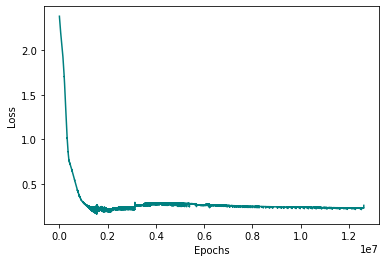

In [3]:
%%time

#this worked best
dinn = DINN(smallpox_data[0], smallpox_data[1], smallpox_data[2], smallpox_data[3], smallpox_data[4], smallpox_data[5], smallpox_data[6], smallpox_data[7], smallpox_data[8])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list ,En_pred_list ,Ei_pred_list ,Ci_pred_list ,I_pred_list ,Q_pred_list ,U_pred_list ,V_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

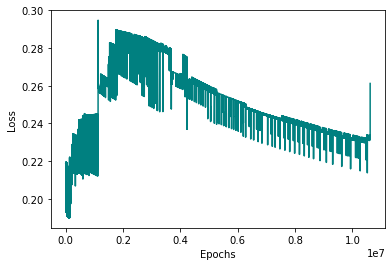

In [4]:
plt.plot(dinn.losses[2000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

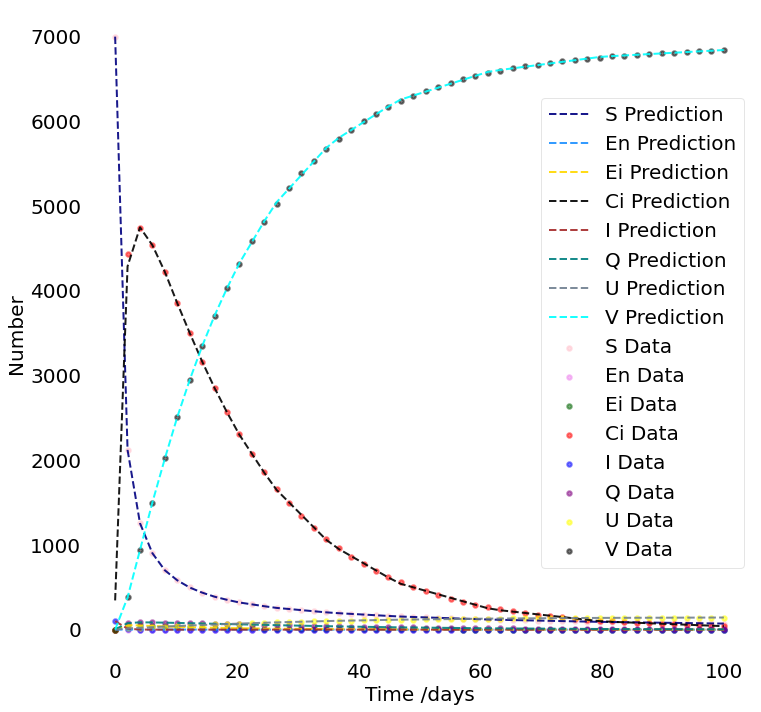

In [5]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.scatter(smallpox_data[0], smallpox_data[1], color =  'pink', alpha=0.5, lw=2, label='S Data',s=20)
ax.plot(smallpox_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[2], color =  'violet', alpha=0.5, lw=2, label='En Data',s=20)
ax.plot(smallpox_data[0], En_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='En Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[3], color =  'darkgreen', alpha=0.5, lw=2, label='Ei Data',s=20)
ax.plot(smallpox_data[0], Ei_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ei Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[4], color =  'red', alpha=0.5, lw=2, label='Ci Data',s=20)
ax.plot(smallpox_data[0], Ci_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Ci Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[5], color =  'blue', alpha=0.5, lw=2, label='I Data',s=20)
ax.plot(smallpox_data[0], I_pred_list[0].detach().numpy(), 'brown', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[6], color =  'purple', alpha=0.5, lw=2, label='Q Data',s=20)
ax.plot(smallpox_data[0], Q_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Q Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[7], color =  'yellow', alpha=0.5, lw=2, label='U Data',s=20)
ax.plot(smallpox_data[0], U_pred_list[0].detach().numpy(), 'slategrey', alpha=0.9, lw=2, label='U Prediction', linestyle='dashed')

ax.scatter(smallpox_data[0], smallpox_data[8], color =  'black', alpha=0.5, lw=2, label='V Data',s=20)
ax.plot(smallpox_data[0], V_pred_list[0].detach().numpy(), 'aqua', alpha=0.9, lw=2, label='V Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('smallpox.pdf')
plt.show()

tensor([0.9759], grad_fn=<AddBackward0>)


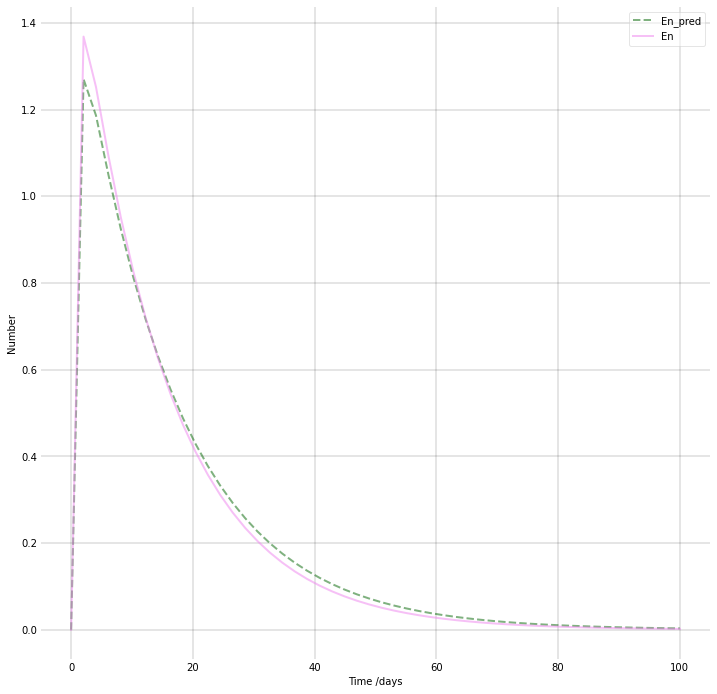

In [6]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions

S0 = 7000
En0 = 0
Ei0 = 0
Ci0 = 0
I0 = 100
Q0 = 0
U0 = 0
V0 = 0
N = 7000

# A grid of time points (in days)
t = np.linspace(0, 100, 50) 

#parameters
chi_1 = dinn.chi_1
chi_2 = dinn.chi_2
epsilon_1 = dinn.epsilon_1
epsilon_2 = dinn.epsilon_2
rho = dinn.rho
theta = dinn.theta
alpha = dinn.alpha
gamma = dinn.gamma

print(rho)

# The SIR model differential equations.
def deriv(y, t,N, chi_1 ,chi_2 ,epsilon_1 ,epsilon_2 ,rho ,theta ,alpha ,gamma):
    S ,En ,Ei ,Ci ,I ,Q ,U, V  = y
    phi = I/S
    beta = (10 * gamma)/(phi*N) #R0 = 10

    dSdt = chi_1 * (1-epsilon_1) * Ci - beta * (phi + rho - phi * rho) * S * I
    dEndt = beta * phi * (1-rho)*S*I - alpha*En
    dEidt = beta * phi*rho*S*I - (chi_1*epsilon_2 + alpha*(1-epsilon_2))*Ei
    dCidt = beta*rho*(1-phi)*S*I-chi_1*Ci
    dIdt = alpha*(1-theta)*En- (theta+gamma)*I
    dQdt = alpha*(1-epsilon_2)*Ei+theta*(alpha*En+I)-chi_2*Q
    dUdt = gamma*I+chi_2*Q
    dVdt = chi_1*(epsilon_2*Ei+epsilon_1*Ci) 

    return dSdt  ,dEndt  ,dEidt  ,dCidt  ,dIdt  ,dQdt  ,dUdt  ,dVdt 


# Initial conditions vector
y0 = S0 ,En0 ,Ei0 ,Ci0 ,I0 ,Q0 ,U0, V0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, chi_1 ,chi_2 ,epsilon_1 ,epsilon_2 ,rho ,theta ,alpha ,gamma))
S ,En ,Ei ,Ci ,I ,Q ,U, V  = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# ax.plot(t, S, 'black', alpha=0.5, lw=2, label='Sh_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[1], 'pink', alpha=0.5, lw=2, label='S')

ax.plot(t, En, 'darkgreen', alpha=0.5, lw=2, label='En_pred', linestyle='dashed')
ax.plot(smallpox_data[0], smallpox_data[2], 'violet', alpha=0.5, lw=2, label='En')

# ax.plot(t, Ei, 'blue', alpha=0.5, lw=2, label='Ei_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ei')

# ax.plot(t, Ci, 'orange', alpha=0.5, lw=2, label='Ci_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[4], 'red', alpha=0.5, lw=2, label='Ci')

# ax.plot(t, I, 'red', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[5], 'blue', alpha=0.5, lw=2, label='I')

# ax.plot(t, Q, 'teal', alpha=0.5, lw=2, label='Q_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[6], 'purple', alpha=0.5, lw=2, label='Q')

# ax.plot(t, U, 'black', alpha=0.5, lw=2, label='U_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[7], 'yellow', alpha=0.5, lw=2, label='U')

# ax.plot(t, V, 'green', alpha=0.5, lw=2, label='V_pred', linestyle='dashed')
# ax.plot(smallpox_data[0], smallpox_data[8], 'black', alpha=0.5, lw=2, label='V')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
S_total_loss = 0
S_den = 0
En_total_loss = 0
En_den = 0
Ei_total_loss = 0
Ei_den = 0
Ci_total_loss = 0
Ci_den = 0
I_total_loss = 0
I_den = 0
Q_total_loss = 0
Q_den = 0
U_total_loss = 0
U_den = 0
V_total_loss = 0
V_den = 0

for timestep in range(len(t)):
    S_value = smallpox_data[1][timestep] - S[timestep]
    S_total_loss += S_value**2
    S_den += (smallpox_data[1][timestep])**2

    En_value = smallpox_data[2][timestep] - En[timestep]
    En_total_loss += En_value**2
    En_den += (smallpox_data[2][timestep])**2

    Ei_value = smallpox_data[3][timestep] - Ei[timestep]
    Ei_total_loss += Ei_value**2
    Ei_den += (smallpox_data[3][timestep])**2
    
    Ci_value = smallpox_data[4][timestep] - Ci[timestep]
    Ci_total_loss += Ci_value**2
    Ci_den += (smallpox_data[4][timestep])**2
    
    I_value = smallpox_data[5][timestep] - I[timestep]
    I_total_loss += I_value**2
    I_den += (smallpox_data[5][timestep])**2
    
    Q_value = smallpox_data[6][timestep] - Q[timestep]
    Q_total_loss += Q_value**2
    Q_den += (smallpox_data[6][timestep])**2
    
    U_value = smallpox_data[7][timestep] - U[timestep]
    U_total_loss += U_value**2
    U_den += (smallpox_data[7][timestep])**2
    
    V_value = smallpox_data[8][timestep] - V[timestep]
    V_total_loss += V_value**2
    V_den += (smallpox_data[8][timestep])**2


S_total_loss  = math.sqrt(S_total_loss/S_den)
En_total_loss  = math.sqrt(En_total_loss/En_den)
Ei_total_loss  = math.sqrt(Ei_total_loss/Ei_den)
Ci_total_loss  = math.sqrt(Ci_total_loss/Ci_den)
I_total_loss  = math.sqrt(I_total_loss/I_den)
Q_total_loss  = math.sqrt(Q_total_loss/Q_den)
U_total_loss = math.sqrt(U_total_loss/U_den)
V_total_loss = math.sqrt(V_total_loss/V_den)

print('S_total_loss: ', S_total_loss)
print('En_total_loss: ', En_total_loss)
print('Ei_total_loss: ', Ei_total_loss)
print('Ci_total_loss: ', Ci_total_loss)
print('I_total_loss: ', I_total_loss)
print('Q_total_loss: ', Q_total_loss)
print('U_total_loss: ', U_total_loss)
print('V_total_loss: ', V_total_loss)

NameError: name 'math' is not defined